# Random Forest Regression for Rogue Wave Prediction

***Model motivation and approach***

In this notebook, we model rogue wave characteristics using a Random Forest regression model. Random Forests are ensemble methods that combine many decision trees trained on random subsets of data and features. By aggregating their predictions, the model reduces variance and captures complex, non-linear interactions without requiring extensive parameter tuning. This makes Random Forests particularly effective for modelling environmental systems where nonlinearity and feature interactions are expected.

Because decision trees split data using threshold rules, Random Forests are inherently **scale-invariant** and do not require feature standardization. This simplifies preprocessing while preserving the physical meaning of each feature.

***Model Training***

Hyperparameter optimization is performed using stratified k-fold cross-validation to maintain proportional representation of rare rogue-wave events in all folds. This improves stability and comparability across validation splits.

We tune the following hyperparameters, selecting ranges that offer good performance while keeping the model small enough for large-scale SHAP analysis:

- **n_estimators** = 100  
  Number of trees in the ensemble. Kept at 100 to balance predictive performance and memory usage.

- **max_depth** = [10, 20, 30]  
  Controls how deep each tree can grow. Deeper trees capture more complexity but risk overfitting.

- **max_samples** = [0.3, 0.4, 0.5]  
  Fraction of the training data used per tree, reducing memory load and increasing ensemble diversity.

- **criterion** = 'friedman_mse'  
  A variance-based split criterion well suited for continuous, approximately Gaussian targets under potentially non-linear relationships.

- **max_features** = 'sqrt'  
  Number of features considered at each split. With 17 features, this yields ~4 features per split (similar to log2) and helps decorrelate trees.

- **min_samples_leaf** = [1, 2, 3, 5, 10, 15]  
  Controls the minimum number of samples needed to form a leaf. Larger values create smoother trees and reduce overfitting.


***Model Evaluation***

To assess predictive performance, we compute:

- **MSE** — sensitive to large errors  
- **MAE** — robust average deviation  
- **R² score** — explained variance  
- **Spearman correlation** — preserves rank information even when relationships are not strictly linear  

Together, these metrics provide a comprehensive view of model accuracy and stability.


***Model Interpretation***

We use SHAP (SHapley Additive exPlanations) to interpret the Random Forest model. SHAP values provide:

- **Global feature importance** — which variables the model relies on most  
- **Local explanations** — how individual features contribute to a specific prediction  
- **Interaction insights** — how combinations of features influence model behaviour  

To compute SHAP efficiently for a large dataset, we use **TreeExplainer** with `feature_perturbation="tree_path_dependent"`. This mode leverages the internal structure of the trained decision trees, using the sample distributions recorded along tree paths. It avoids the need to load the full dataset into memory and is the recommended method for tree-based models. A known limitation is that the SHAP **expected value** may differ slightly from the mean model prediction. This arises because scikit-learn stores only the subsampled training data used by each tree. The TreeExplainer integrates over these recorded samples rather than the full dataset. Eliminating this discrepancy would require an Independent masker over the full training set, which is computationally too havy for our data size. We use the default `model_output="raw"` to keep SHAP values on the same scale as the regression output.

SHAP values are computed for:

- **160,000 training waves**  
- **40,000 test waves**

Training-set SHAP values reflect learned dependencies, while test-set values show how well these dependencies generalize. Comparing both sets helps identify overfitting and highlights which features consistently drive predictions across unseen data.

***Conclusion***

The Random Forest model provides strong predictive performance for estimating the Abnormality Index (AbnI), achieving high performance on both the training and test sets with only a small decline in performance, indicating limited overfitting and good generalization. The high Spearman correlations show that the model preserves the ordering of wave abnormality exceptionally well, even where prediction errors occur.

SHAP analyses for both training and test data reveal a highly consistent ranking of important features. The most influential predictors are the depth parameter (kh), deep-water wavelength (L_deep), atmospheric pressure, significant wave height, and wind-related variables. These features dominate the model’s behaviour in both datasets. The SHAP beeswarm and dependence plots show clear nonlinear relationships. Higher kh and longer wavelengths increase predicted abnormality, while lower atmospheric pressure and stronger winds contribute positively as well. Spectral parameters display more complex but consistent interactions.


**Imports**

In [1]:
import sys
import pickle
import shap
import pandas as pd

import matplotlib.pyplot as plt

sys.path.append('./')
sys.path.append('../scripts/')
import utils

In [2]:
# we run the model training on a compute cluster 
# we load the model and cross-validation results here
file_cv_results = "../results/rf/cv_results.csv"
file_data_model = "../results/rf/model_and_data.pkl"
file_shap_train = "../results/rf/train_shap.pkl"
file_shap_test = "../results/rf/test_shap.pkl"

Model training was conducted on a high-performance computing (HPC) cluster equipped with an Intel Xeon 6248R CPU (96 cores and 192 threads) and 744 GB of RAM. The Elastic Net model was trained using 50 of the available CPU cores and 100 GB of memory. Hyperparameter optimization was performed via grid search with five-fold cross-validation over 54 candidate parameter combinations, yielding a total of 270 fitted models. The complete cross-validation procedure required 20 min with one fit taking on average 4.5 sec.

For reproducibility use the following scripts:

- model training python script: *scripts/train_model.py*
- HPC configuration for linear model: *scripts/train_rf.sh*

**Model Evaluation**

In [3]:
model, X_train, y_train, y_train_cat, X_test, y_test, y_test_cat = utils.load_data_and_model(file_data_model, output=False)
cv_results = pd.read_csv(file_cv_results, index_col=0)  
cv_results

Loaded the following model: RandomForestRegressor(criterion='friedman_mse', max_depth=30,
                      max_features='sqrt', max_samples=0.5, random_state=42) with an average tree depth of : 30.0


,criterion,max_depth,max_features,max_samples,min_samples_leaf,n_estimators,score
0,friedman_mse,30,sqrt,0.5,1,100,0.948741
1,friedman_mse,30,sqrt,0.4,1,100,0.944238
2,friedman_mse,30,sqrt,0.5,2,100,0.942038
3,friedman_mse,30,sqrt,0.4,2,100,0.936684
4,friedman_mse,30,sqrt,0.3,1,100,0.936528
5,friedman_mse,30,sqrt,0.5,3,100,0.935187
6,friedman_mse,30,sqrt,0.4,3,100,0.928831
7,friedman_mse,30,sqrt,0.3,2,100,0.927813
8,friedman_mse,30,sqrt,0.5,5,100,0.921615
9,friedman_mse,30,sqrt,0.3,3,100,0.918180


Evaluate on Training Set


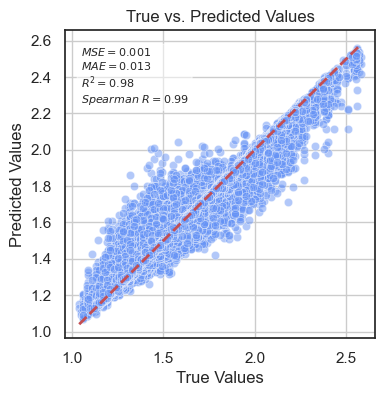

Evaluate on Test Set


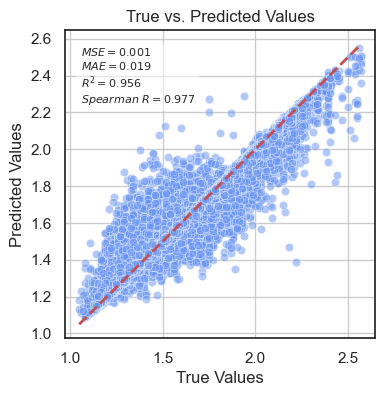

In [4]:
# Evaluate model on train and test set
_, _, _, _, _, _ = utils.evaluate_best_regressor(model, X_train, y_train, dataset="Training", plot=True)
_, _, _, _, _, _ = utils.evaluate_best_regressor(model, X_test, y_test, dataset="Test", plot=True)

**Model Interpretation**

Interpretation on Training Set

In [ ]:
# Load and unpack the shap values
with open(file_shap_train, "rb") as handle:
    explanation_train = pickle.load(handle)

In [ ]:
shap.plots.bar(explanation_train, max_display=17, show=False)
plt.title("SHAP Summary for Random Forest - Training Set")
plt.show()

In [ ]:
shap.plots.beeswarm(explanation_train, max_display=17, show=False)
plt.title("SHAP Beeswarm for Random Forest - Training Set")
plt.show()

In [ ]:
utils.plot_shap_dependence(explanation_train)

Interpretation on Test Set

In [6]:
# Load and unpack the shap values
with open(file_shap_test, "rb") as handle:
    explanation_test = pickle.load(handle)

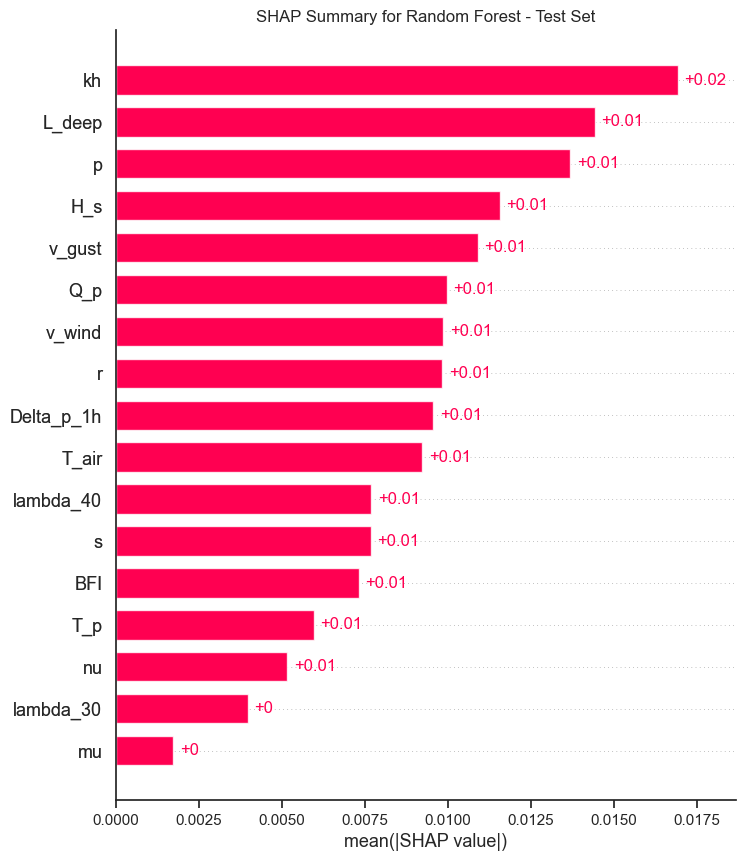

In [7]:
shap.plots.bar(explanation_test, max_display=17, show=False)
plt.title("SHAP Summary for Random Forest - Test Set")
plt.show()

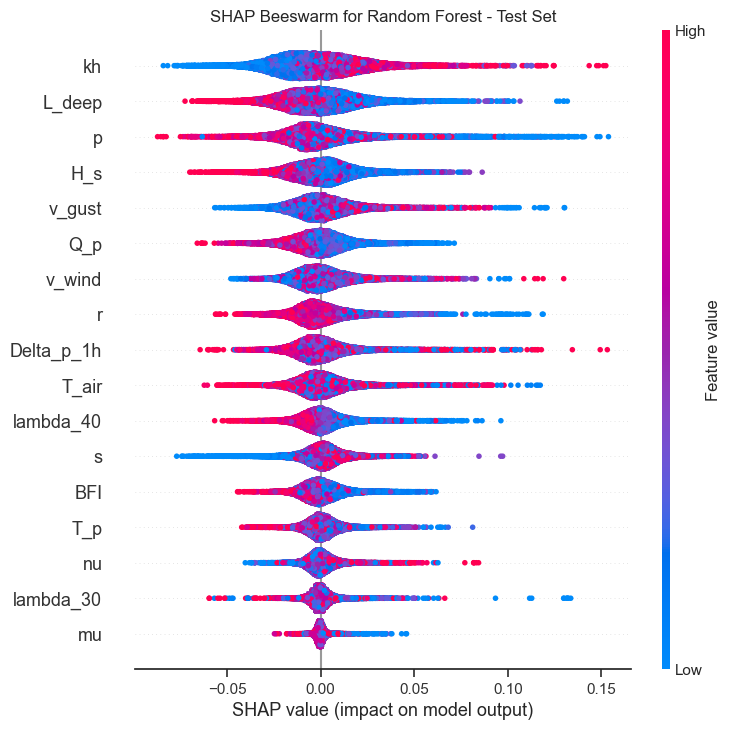

In [8]:
shap.plots.beeswarm(explanation_test, max_display=17, show=False)
plt.title("SHAP Beeswarm for Random Forest - Test Set")
plt.show()

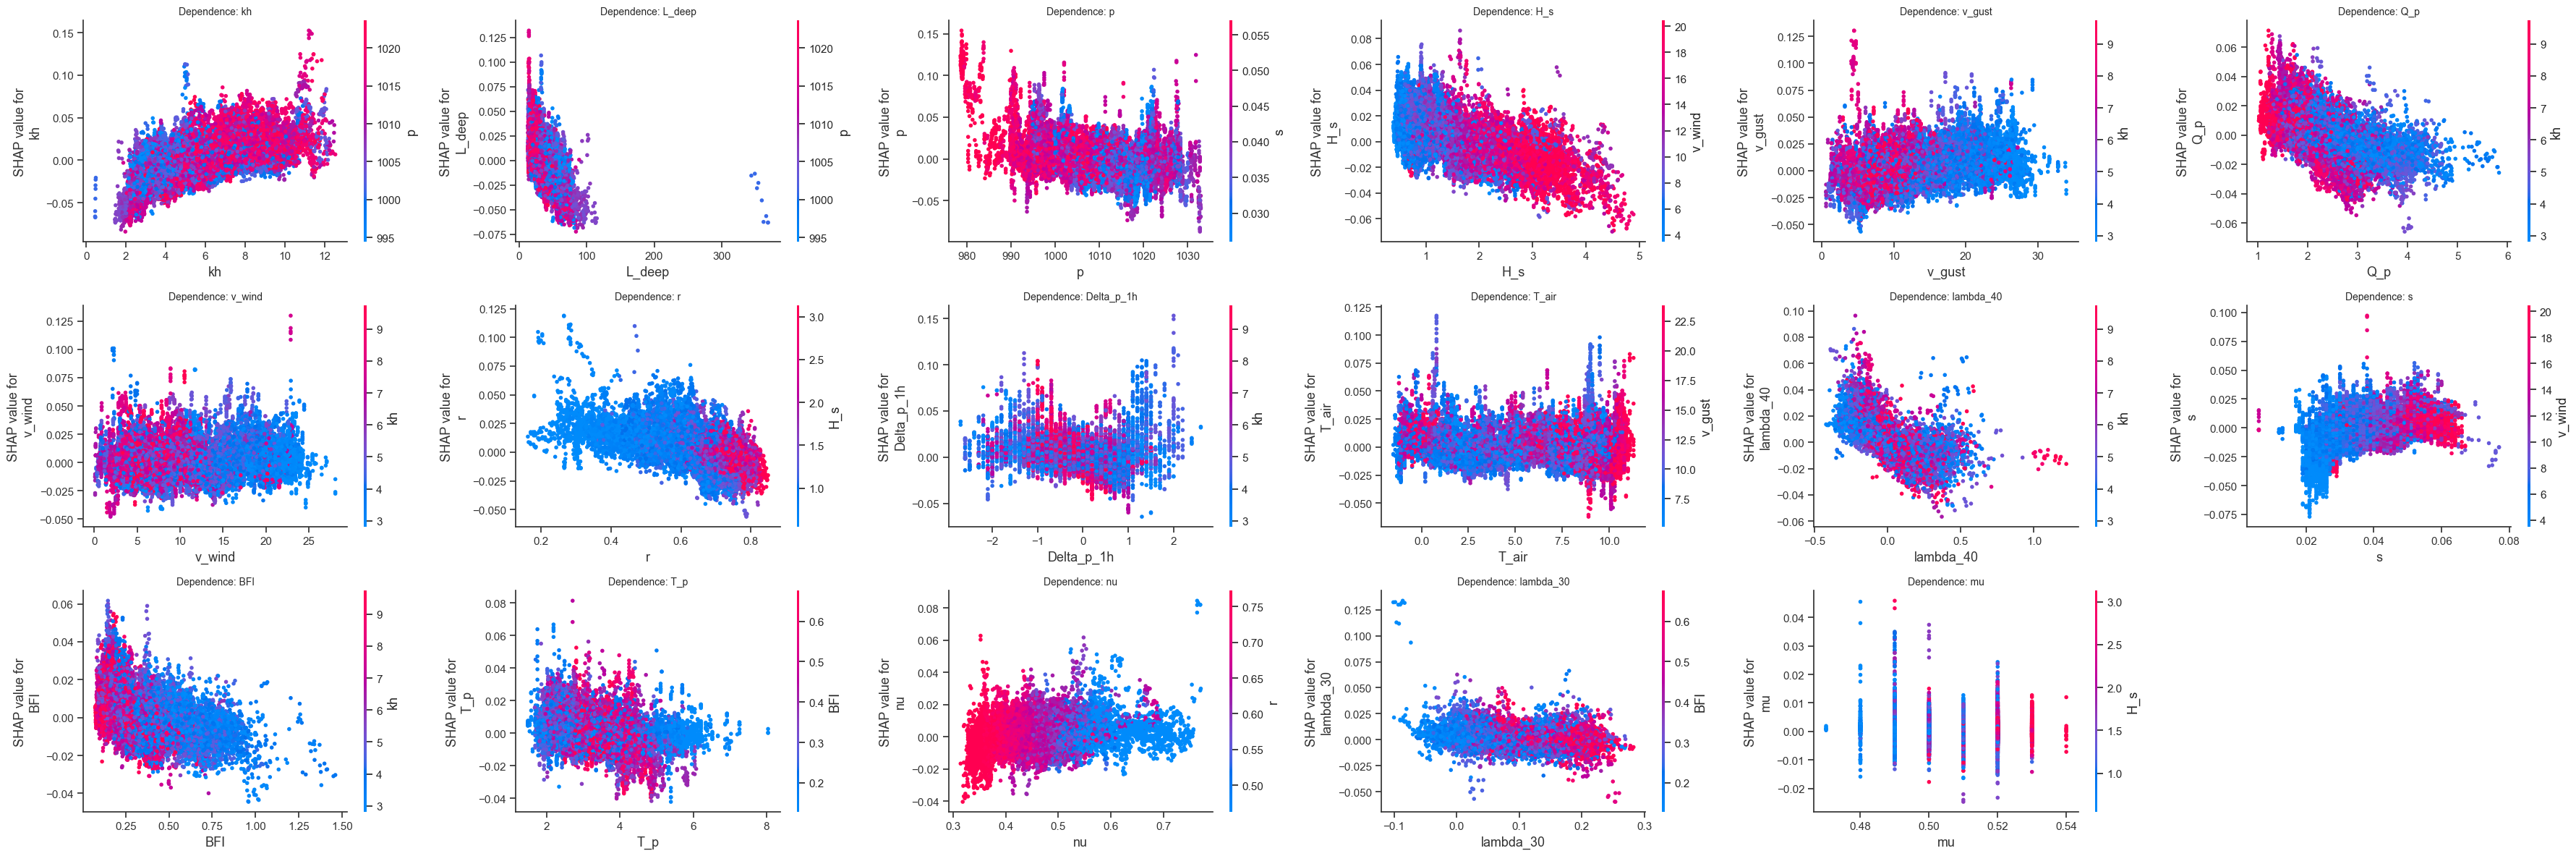

In [9]:
utils.plot_shap_dependence(explanation_test)